# Regressions

$X = (0,1)$

$Y = sin(2\pi X)$

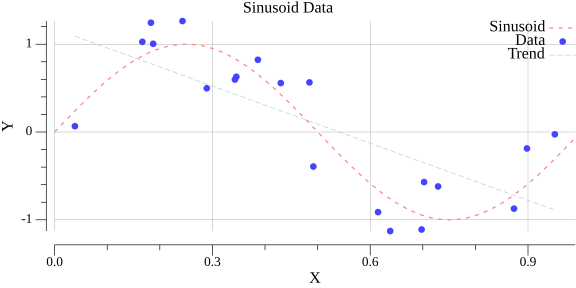

In [1]:
// deno-lint-ignore-file

import { display } from "https://deno.land/x/display@v0.1.1/mod.ts";
import pl from "npm:nodejs-polars";
import plot from "../plot/mod.ts";

const data = await Deno.readTextFile("assets/X_Y_Sinusoid_Data.csv");
const df = pl.readCSV(data, { sep: "," });

const real = pl.DataFrame({ x: new Array(100).fill(0).map((_, i) => i / 100)}).select(
    pl.col('x'),
    pl.col('x').mul(2).mul(3.14).sin().alias('y')
);

const draw = (x, y, title = "Sinusoid Data") => 
  plot.DrawPlot(
      { 
          title,
          width: 6,
          height: 3,
          XLabel: "X", 
          YLabel: "Y", 
      }, 
      { type: "line", data: [real.x, real.y], legend: "Sinusoid", lineDashes: [3, 4], lineColor: "#ff8888", lineWidth: 1 },
      { type: "scatter", data: [x, y], legend: "Data", lineDashes: [3, 4], lineWidth: 2, glyphColor: "#4444ff", glyphShape: "circle" },
      { type: "trend", data: [x, y], legend: "Trend", lineDashes: [4, 2], lineColor: '#aacccc', lineWidth: .5 },
  );

  const comparePredicted = (x, y, predicted) => plot.DrawPlot(
    { 
        width: 7,
        height: 4,
        XLabel: "X", 
        YLabel: "Y", 
    }, 
    { type: "line", data: [real.x, real.y], legend: "Sinusoid", lineDashes: [3, 4], lineColor: "#ff8888", lineWidth: 1 },
    { type: "linePoints", data: [x, y], legend: "Test Data", lineDashes: [3, 4], lineColor: "#8888ff",  glyphColor: "#4444ff", glyphShape: "circle" },
    { type: "linePoints", data: [x, predicted], lineWidth: .5, legend: "Predicted",  glyphColor: '#f00', glyphShape: "pyramid" },
);


draw(df.x, df.y);

# Polynomial Tranformation

First we try to predict values without polynomial transformation:

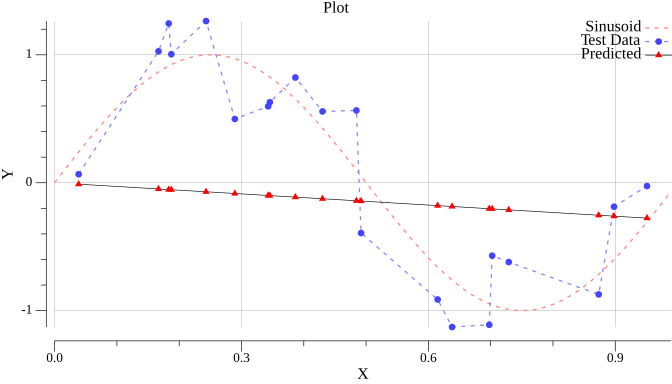

In [2]:
import regr from '../regr/mod.ts';

const linregWoPoly = regr.Linear();

linregWoPoly.fit(df.drop('y').rows(), df.select('y').rows());
const predWoPoly = linregWoPoly.predict(df.drop('y').rows());

comparePredicted(df.x, df.y, predWoPoly);

Now augment our dataset with high degree polynomial:

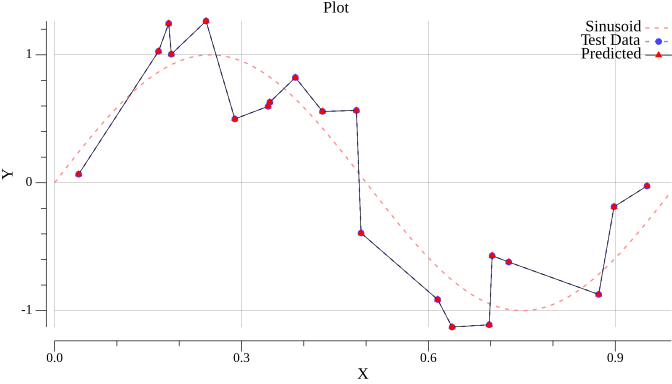

In [3]:
import { polynomialTransform } from '../encoding.ts';



const polyFeatures = polynomialTransform(df.drop('y'), 36, false, false)

const [polyX, polyY] = [polyFeatures, df.select('y')]

const linregPoly = regr.Linear();

linregPoly.fit(polyX.rows(), polyY.rows());
const predY = linregPoly.predict(polyX.rows());

comparePredicted(df.x, df.y, predY);


In [4]:
linregPoly.score(df.select('y').rows(), pl.DataFrame({"py":predY}).rows());

0.9999999469410812

# ElasticNet

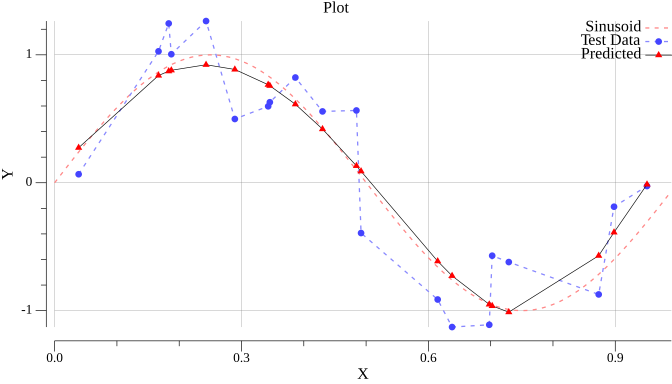

In [5]:
const elasticNetPoly = regr.ElasticNet(1000, 0.0001);
elasticNetPoly.fit(polyX.rows(), polyY.rows());
const predEnetY = elasticNetPoly.predict(polyX.rows());

comparePredicted(df.x, df.y, predEnetY);

# Lasso

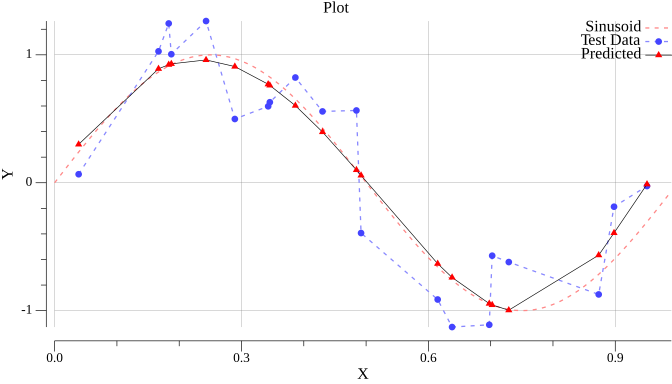

In [6]:
const lassoPoly = regr.Lasso(1000, 0.0001);
lassoPoly.fit(polyX.rows(), polyY.rows());
const predLassoY = lassoPoly.predict(polyX.rows());

comparePredicted(df.x, df.y, predLassoY);

In [7]:
lassoPoly.score(df.select('y').rows(), pl.DataFrame({"py":predLassoY}).rows());


0.8637104981289901